## Transforming Data

Oft times transforming data can be helpful when modeling.  The transformations can serve the purpose of stabilizing the variance of the data, i.e., decouple the variance from the mean. 

You need to also be well aware of what this transform means to the regression output itself and do you need to account for transformation bias in certain instances.  

### Agenda

* Box Cox Transform
* Inverse Hyperbolic Sine Transform
* Transformation Considerations


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
from scipy.stats import jarque_bera
from scipy.optimize import minimize
%matplotlib inline

## Data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2366bf98>],
      dtype=object)

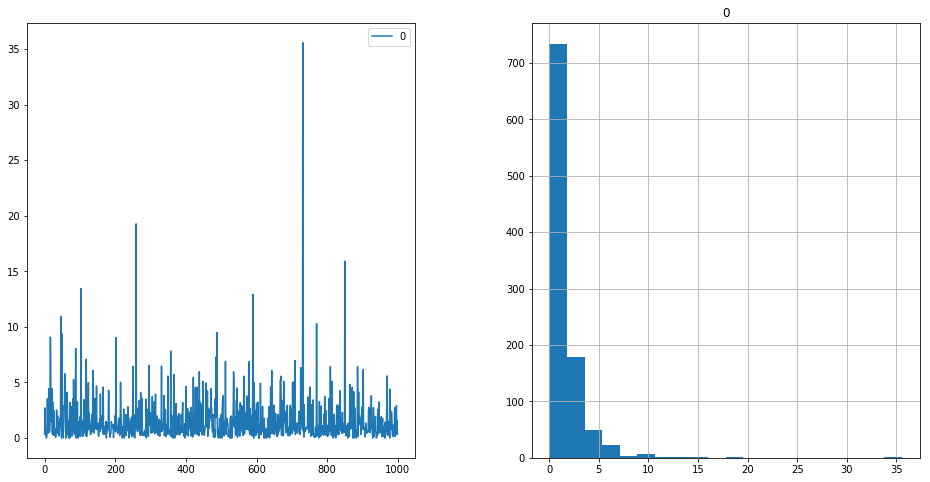

In [42]:
np.random.seed(123)
x = np.random.lognormal(0, 1, 1000)
x = pd.DataFrame(x * np.random.binomial(1, 0.95, 1000))
fig, ax = plt.subplots(1,2,figsize=[16,8])
x.plot(ax=ax[0])
x.hist(ax=ax[1], bins=20)

#### Box Cox transform

$$ y = \begin{cases} 
                \frac{(x + c)^\lambda - 1 }{\lambda} & \lambda \ne 0 \\
                \log(x + c) & \lambda = 0
       \end{cases}$$              

for some $c$ such that $x + c > 0$. Notice that that 

$$ \lim_{\lambda \to 0} \frac{(x + c)^\lambda - 1 }{\lambda} = \log(x + c)$$

This is a generalization of power transformations.  

Typically $\lambda$ would be choose as the solution to some optimization problem.  Assumpitons are required to solve this as an optimization problem. 

* SAS' `%BOXCOXAR` tries a range of $\lambda$ by transforming the series and fitting an autoregressive model to the transformed series.  
* Scipy `boxcox` finds the $\lambda$ that maximizes the normal log-likelihood function and return it as the second output argument.  
* $\lambda = 0, c = 1$ can work well for non-negative data.
* you can always turn this into an optimzation problem in $c$ and $\lambda$.  

Consierations 

* $c$ must be choosen such that $x + c > 0$.  This may typically be choosen based on the training data, or understanding of the values $x$ may take.  For example if $X$ is non-negative, setting $c = 1$, will keep your transform well defined, but what does this imply?  In studies involving income, setting $c=1$ effectively means you are giving everyone \$1, ["[w]hich rumor has it will get your paper rejected by the AER"](https://chrisblattman.com/2011/11/15/if-you-know-what-ln1income-is-and-why-its-a-headache-you-should-read-this-post/). 
* Check out  Yeo–Johnson transform that will handle negative and zero values (more complex) 
 



#### Inverse Hyperbolic Sine

Another transform that is useful for series that can take on values in the continuum is Inverse Hyperbolic Sine

$$ y = \frac{\sinh^{-1}( x\theta)}{\theta}$$              

for some $\theta \in \mathbb{R}$.  

* $\sinh^{-1}$ is defined on $\mathbb{R}$. 
* $\sinh^{-1}$ is odd so $\sinh^{-1}(-x) = -\sinh^{-1}(x)$. 
* for small $x, \sinh^{-1}(x) \approx x$. 
* for large $x, \sinh^{-1}(x) \approx \log(2x)$. 

Given the parity of $\sinh^{-1}$, it is fine to restrict attention to $\theta \ge 0$.

#### Considerations

* Interpretting results may be difficult.  
* Transformation bias.  Need to esimtate the transformation bias.


#### General Considerations for Transforming Variables

If $X$ is a random variable and $f$ is some monotone transform there is no guarantee that $\mathbb{E}[f(X)]$ be equal to $f(\mathbb{E}[X])$.  This means that you need to be aware what back transforming yields.  

#### Log1P Transform 

Box Cox with $c = 1$ and $\lambda = 1$. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a25d95d30>],
      dtype=object)

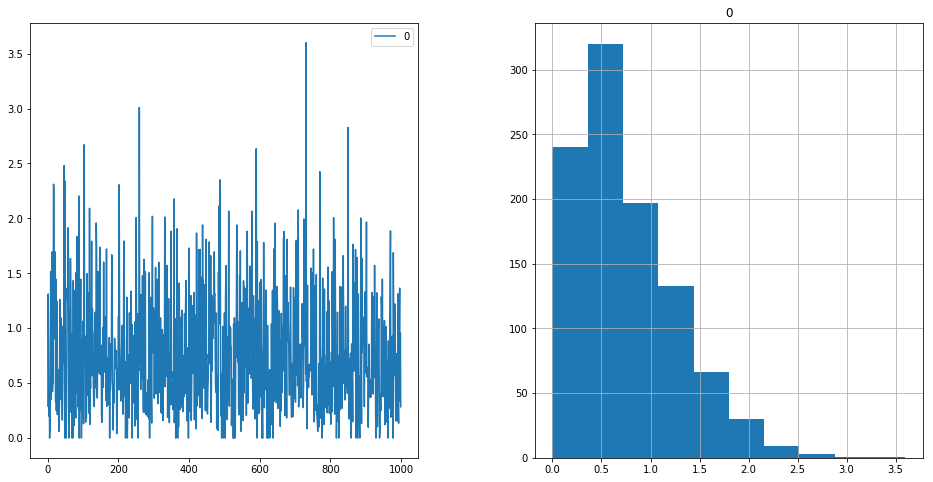

In [95]:
y = np.log1p(x)
fig, ax = plt.subplots(1,2,figsize=[16,8])
y.plot(ax=ax[0])
y.hist(ax=ax[1])

#### Box Cox Transform

0    0.01
dtype: float64 (42.77336550886061, 5.150883053417488e-10)
0    1.0
dtype: float64 (19.98724787629475, 4.569032733536815e-05)
0    10.0
dtype: float64 (46.76137774400594, 7.012868064038003e-11)


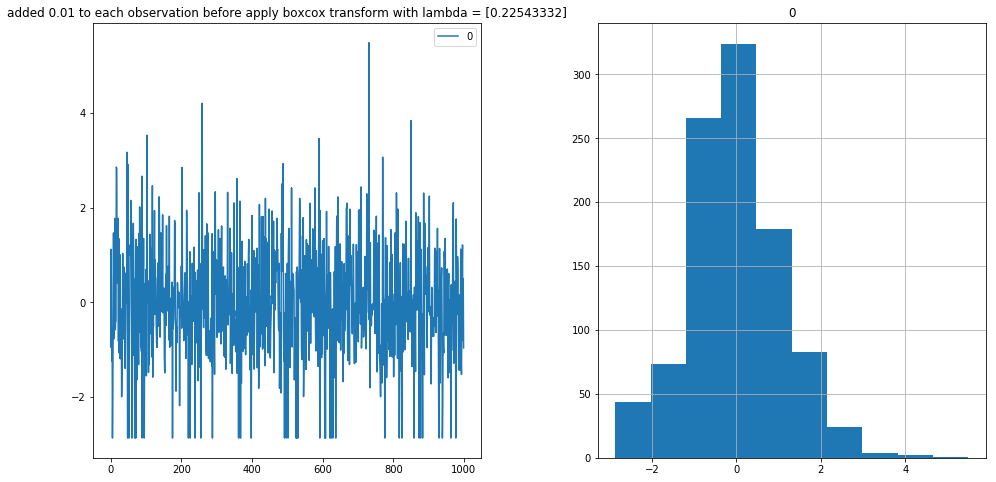

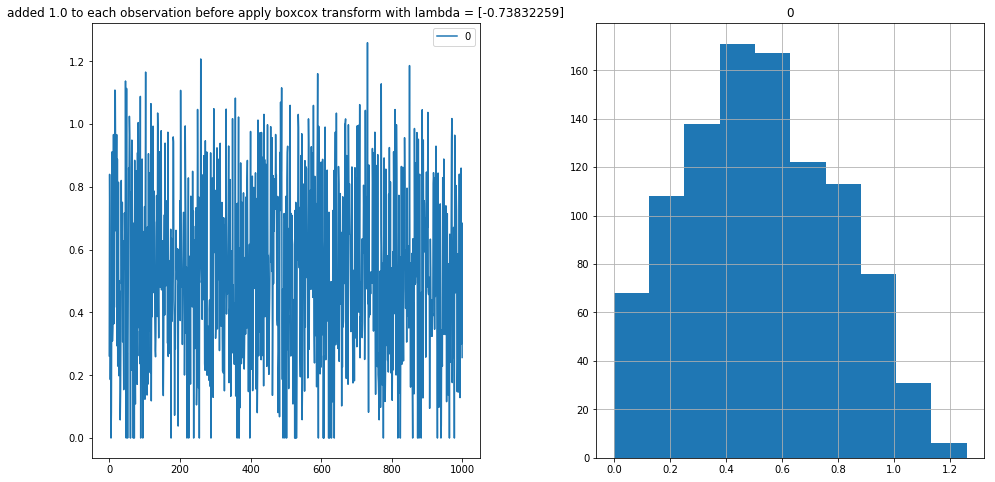

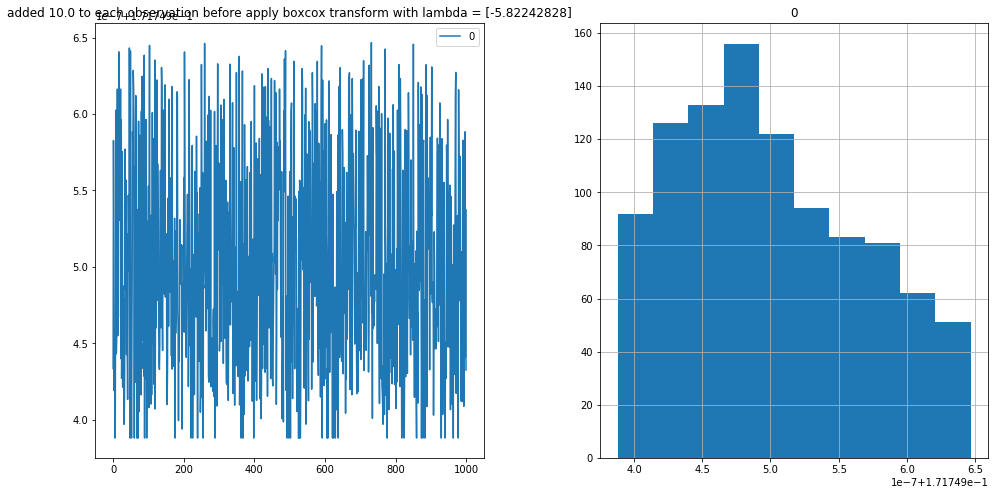

In [165]:
for some_amount in [1e-2, 1, 10]:
    c = np.abs(x.min()) + some_amount
    try: 
        result, lmbda = boxcox(x + c)
        fig, ax = plt.subplots(1,2,figsize=[16,8])
        desc = "added {} to each observation before apply boxcox transform with lambda = {}".format(c[0], lmbda)
        pd.DataFrame(result).plot(ax=ax[0], title=desc)
        pd.DataFrame(result).hist(ax=ax[1])
        print(c, jarque_bera(result))
    except Exception as e:
        print(e)


#### inverse hyperbolic sine


In [77]:
class IHS(object):
    def __init__(self, x):
        self.x = x

    def neg_like(self, theta):
        y = np.arcsinh(theta * self.x) / theta
        n = y.shape[0]
        y_mu = y.mean()
        y_std = y.std()
        z = ((y - y_mu)/y_std).values.ravel()
        lik = - n / 2 * np.log(2 * np.pi * y_std**2) - 1/2*(z**2).sum() - 1/2*np.log(self.x**2*theta**2 + 1).sum()
        return -lik / n 
  
    def transform(self, theta):
        return np.arcsinh(theta * x.values.ravel()) / theta

In [78]:
ihs = IHS(x)
soln = minimize(IHS(x).neg_like, 1, method='L-BFGS-B', tol=1e-6, options={'disp': True}, bounds = [(0,np.inf)])
optimal_theta = soln.x[0]

4.999418683756517 (1.2788302565374703, 0.5276009126803292)


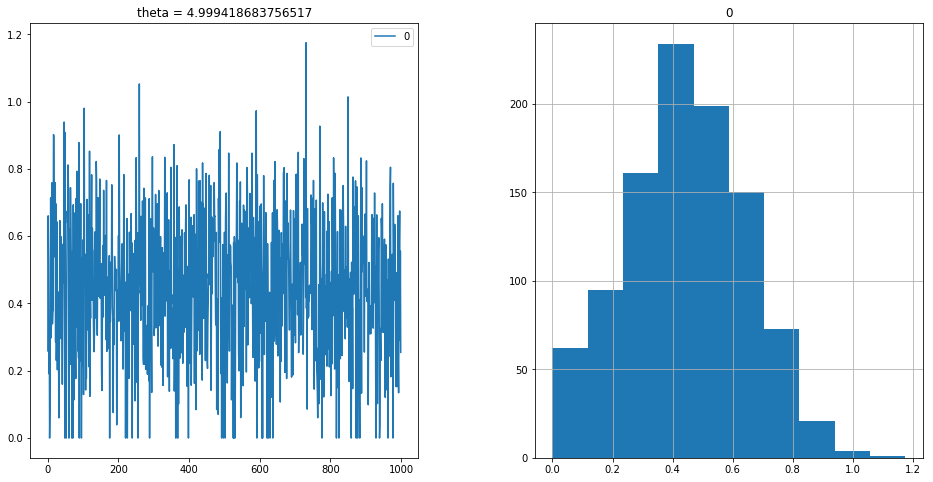

In [97]:
for theta in [optimal_theta]:
    y = ihs.transform(theta)
    fig, ax = plt.subplots(1,2,figsize=[16,8])
    desc = "theta = {}".format(theta)
    pd.DataFrame(y).plot(ax=ax[0], title=desc)
    pd.DataFrame(y).hist(ax=ax[1])
    
print(theta, jarque_bera(y))


Keep in mind - modeling of transformed variable
1. modeling logs?? the exponential of the mean of the logged series is the geometric mean of the series.  Moreover, we know the geometric mean $\le$ arithmetic mean, so, again, don't expect them to be equal.  
2. In general back transforming will not be the mean. 
2. If data post transformation has a symmetric distribution, back transforming your prediction is closer to the conditional median.   
3. If $X \sim \text{Log Normal}(\mu, \sigma^2)$, then the expected value of $X$ is $\exp(\mu + \frac{1}{2}\sigma^2)$.

## Back transforming

As mentioned there will be some transformation bias involved in everything discussed up to this point when considering the problem of estimating the conditional mean, i.e., you are using MSE optimization metric for your modeling.  If you are using MAE as an optimization metric, the solution to is a estimation of the median, and this is invariant under monotone transforms in the sense that if X is random variable with median $m$, and $f$ is a monotone transform of $X$, then $f(m)$ is the median of $f(X)$.  

#### Bias

The difference between the mean of the series and the back transformed value is the bias. Sometimes it is easy to figure out and other times, not so much.  

If $X \sim \text{Log Normal}(\mu, \sigma^2)$, then $\mu$ and $\sigma^2$ is the mean and var of the log transformed series.  Then the bias is $\frac{1}{2}\sigma^2$.  

In thos cases where it is quiet difficult to figure out, a nice approximation can be found by using an old friend.  

If $X$ is a random variable, the expected value of $f(X)$ can be estimated as 

$$\mathbb{E}[f(X)] \approx f(\mu_X) + f'(\mu_X)\mathbb{E}[X - \mu_X] +  \frac{1}{2}f''(\mu_X)\mathbb{E}[(x - \mu_X)^2] \;\;\;\;\;\;\;(1)$$

In the above notce that $\mathbb{E}(X - \mu_X) = 0$, and $\mathbb{E}[(x - \mu_X)^2] = \sigma^2$.

So if $f = \exp$, 

then 

$$\mathbb{E}[f(X)] = \exp(\mu_X)\left(1 + \frac{1}{2}\sigma_X^2\right)$$

With $f = \sinh$, i have no idea what the analytic solution is, so an approximation is very useful

$$\mathbb{E}[f(X)] = \frac{1}{\theta}\sinh(\theta \mu_X) + \frac{1}{2}\sigma_X^2 \theta \sinh(\theta \mu_X)$$

Easily use $(1)$ to approximate expected value of Box Cox transform

In [164]:
mu_y = y.mean()
var_y = y.var()

print("biased estimate {:.2}".format( (np.sinh(optimal_theta*mu_y) / optimal_theta)))

print("correcting bias {:.2}".format(1/optimal_theta * np.sinh(optimal_theta * mu_y) + 1/2 * var_y * optimal_theta * np.sinh(optimal_theta * mu_y)))

biased estimate 0.9
correcting bias 1.4


In [160]:
x.mean()

0    1.513474
dtype: float64

In [127]:
np.median(x)

0.9043183782884276

In [128]:
## other methodabs

Might also just estimate bias empirically on training data. 

$$\text{argmin}_b \sum_n \frac{1}{n}(f(x) - f(\bar{x}) - b)^2$$

or 

$$\text{argmin}_b \sum_n \frac{1}{n}(f(x) - f(\bar{x} + b))^2$$

I don't know??  Not sure which is most appropriate.  

## some good readings

https://en.wikipedia.org/wiki/Power_transform

https://worthwhile.typepad.com/worthwhile_canadian_initi/2011/07/a-rant-on-inverse-hyperbolic-sine-transformations.html

https://stats.stackexchange.com/questions/26363/inverse-hyperbolic-sine-transformation-estimation-of-theta 

https://otexts.com/fpp2/transformations.html  - see eq (3.2) for Box Cox back transform with bias approx.  This leverages the taylor series approx.  We didn't discuss the bias approx with respect to time series forecasting.  I haven't thought this through, but I may rely on an empirical based approach to estimate bias.  

https://en.wikipedia.org/wiki/Taylor_expansions_for_the_moments_of_functions_of_random_variables